In [1]:
! pip install tensorflow

# Implémentation de l'algorithme Unet pour faire de la segmentation d'image

Dans le cadre de ce projet, nous aimerions utiliser un algorithme de deep learning adapté au traitement des images pour faire de la segmentation binaire sur des images RGB. Ici nous allons étudier des images satellites, notre objectif est de pouvoir détecter les glissements de terrain sur un territoire montagneux. Nous avons à notre disposition un dataset extrait de Kaggel initié par l'IARAI (Institute of Advanced Research in Artificial Intelligence) dans le projet landslide4sense 2022. Vous pouvez lire l'article de recherche en lien avec ce sujet au lien suivant : https://arxiv.org/abs/2206.00515

lien du dataset : https://www.kaggle.com/code/niyarrbarman/binary-image-segmentation-using-segformer/input

Dans ce notebook nous allons recoder l'algorithme Unet pour effectuer la classification sémantique de nos images, nous procèderons par la suite à de la data augmentation si besoin.


In [2]:
# Modules import

import os,re
import sys
import random
import warnings

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.io import imread, imshow
import cv2


from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras import backend

In [3]:
## Drive Connexion
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
dossier = "/content/drive/MyDrive/CNN_fine_tuning"

# create permament directory in gdrive
data_dir_path = '/content/drive/MyDrive/CNN_fine_tuning'
os.makedirs('/content/drive/MyDrive/CNN_fine_tuning',exist_ok=True)
os.listdir('/content/drive/MyDrive/CNN_fine_tuning')

Mounted at /content/drive


['TP1_image_treatment.ipynb',
 'Unet_CNN.ipynb',
 'archive.zip',
 'data_TP_mathis',
 'TP3',
 'dataset_unet',
 'Copie de TP2_MathisCordier_UNet.ipynb',
 'SAM',
 'Fine_tuning_Sam.ipynb',
 'TP_Unet_evaluation.ipynb']

In [4]:
## Unzip data if you need

import zipfile

chemin_zip = '/content/drive/MyDrive/CNN_fine_tuning/archive.zip'  # Modifiez selon votre chemin
chemin_extraction = '/content/drive/MyDrive/CNN_fine_tuning'  # Le dossier où extraire les fichiers
name_folder_zip = '/dataset_unet' # nom du folder zip

def unzip(chemin_zip,chemin_extraction,name_folder_zip):
  """fonction qui permet de unziper un dossier"""
  if not os.path.exists(chemin_extraction+name_folder_zip):
    with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
      zip_ref.extractall(chemin_extraction)
    print('Extraction terminée.')
  else:
    print('Extraction déjà faite.')

unzip(chemin_zip,chemin_extraction,name_folder_zip)


Extraction déjà faite.


# Chargement des données, visualisations et preprocessing

In [ ]:

TRAIN_PATH = '/content/drive/MyDrive/CNN_fine_tuning/dataset_unet/train'
TEST_PATH = '/content/drive/MyDrive/CNN_fine_tuning/dataset_unet/test'
VAL_PATH = '/content/drive/MyDrive/CNN_fine_tuning/dataset_unet/validation'

In [ ]:
#Train
train_path_images = os.path.join(TRAIN_PATH,'images')
train_path_masks = os.path.join(TRAIN_PATH,'masks')

#Test
test_path_images = os.path.join(TEST_PATH,'images')
test_path_masks = os.path.join(TEST_PATH,'masks')

#Val
val_path_images = os.path.join(VAL_PATH,'images')
val_path_masks = os.path.join(VAL_PATH,'masks')


In [ ]:
def load_image_mask(image_path, mask_path):
  "With the image path and mask path it return two tensors, one for the image and an other for the mask "
  image = cv2.imread(image_path, cv2.IMREAD_COLOR)
  mask = np.expand_dims(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE),-1)

  return image,mask

def list_images_masks(path_images,path_masks):
  """Return an aligned list of images and a list of mask"""

  #display a list and sort by name
  images_files = sorted(os.listdir(path_images))
  masks_files = sorted(os.listdir(path_masks))

  Images, Masks = [],[]

  for i,m in tqdm(zip(images_files,masks_files)):
    try:
      image,mask = load_image_mask(os.path.join(path_images,i), os.path.join(path_masks,m))
      Images.append(image)
      Masks.append(mask)
    except:
      print(i,m)

  return np.array(Images), np.array(Masks)

## Cette étape est très longue, il faut réfléchir à comment réduire le temps de chargement des données avec de la parallélisation par exemple


In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def load_image_mask_parallel(image_path, mask_path):
  "With the image path and mask path it return two tensors, one for the image and an other for the mask "
  try:
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    mask = np.expand_dims(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE),-1)
    return image, mask
  except Exception as e:
    print(f"Erreur lors du chargement de {image_path} et {mask_path}: {e}")
    return None, None

def list_images_masks_parallel(path_images, path_masks, max_workers=10):
  """Return an aligned list of images and a list of mask and use parallelisme"""

  images_files = sorted(os.listdir(path_images))
  masks_files = sorted(os.listdir(path_masks))

  with ThreadPoolExecutor(max_workers=max_workers) as executor: #Permet de faire du parallélisme et donc de racourcir le temps d'exécusion
      futures = [executor.submit(load_image_mask_parallel, os.path.join(path_images, i), os.path.join(path_masks, m))
                  for i, m in tqdm(zip(images_files, masks_files))]

      results = [future.result() for future in as_completed(futures)]

  # Filtrer les résultats None
  results = [result for result in results if result[0] is not None and result[1] is not None]

  if results:
      Images, Masks = zip(*results)  # Déballer les images et les masques
      return np.array(Images), np.array(Masks)
  else:
      return np.array([]), np.array([])

# Utilisation de la fonction optimisée
Images_train, Masks_train = list_images_masks_parallel(train_path_images, train_path_masks)
Images_test, Masks_test = list_images_masks_parallel(test_path_images, test_path_masks)
Images_val, Masks_val = list_images_masks_parallel(val_path_images, val_path_masks)

In [ ]:
# Shape vérification

print(Images_train.shape)
print(Images_test.shape)
print(Images_val.shape)
print()
print(Masks_train.shape)
print(Masks_test.shape)
print(Masks_val.shape)

(1384, 128, 128, 3)
(199, 128, 128, 3)
(396, 128, 128, 3)

(1384, 128, 128, 1)
(199, 128, 128, 1)
(396, 128, 128, 1)


## Visualisation Image-Mask

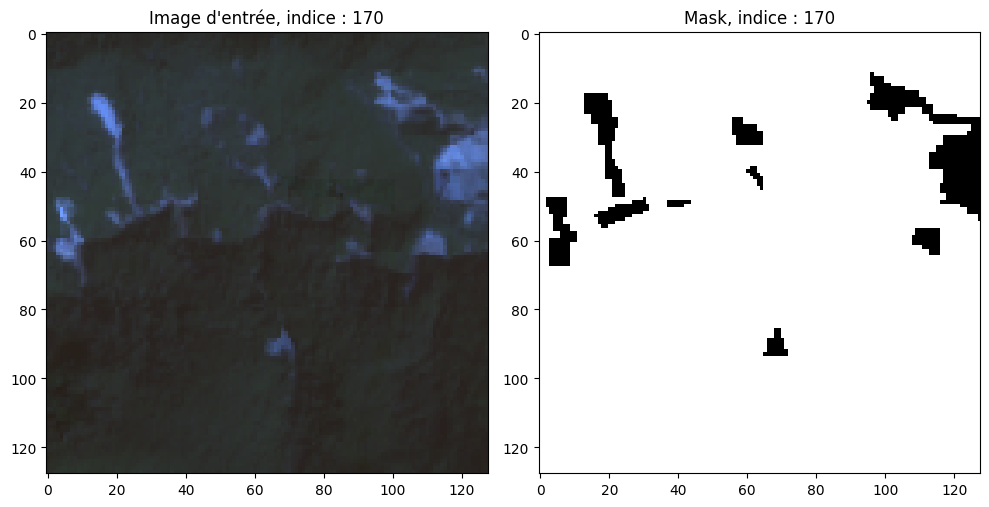

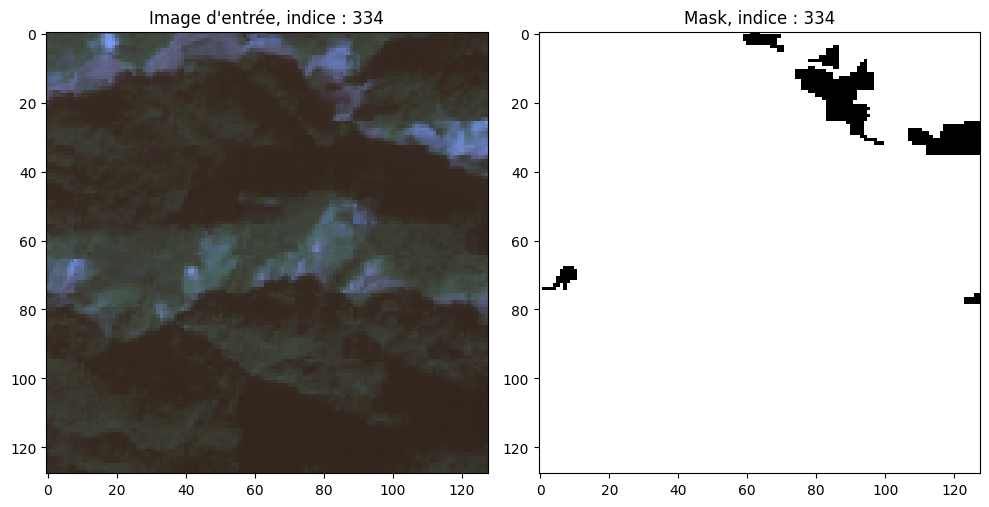

In [ ]:
def show_randomly_one_image(Images, Masks):
  "Randomly choose an image and the following mask. Display them side by side"
  indice = np.random.randint(len(Images))
  fig = plt.figure(figsize=(10,10))
  plt.subplot(121)
  imshow(np.squeeze(Images[indice]))
  plt.title(f"Image d'entrée, indice : {indice}")
  plt.subplot(122)
  imshow(np.squeeze(Masks[indice]), cmap='gray_r')
  plt.title(f'Mask, indice : {indice}')
  plt.show()

show_randomly_one_image(Images_train, Masks_train)
show_randomly_one_image(Images_val, Masks_val)

À ce stade de l'étude, il est assez difficile de détecter un glissement de terrain sans avoir une réelle expertise. La couleur semble être un facteur déterminant de décision. L'inclinaison et la forme ne semble pas être très discriminantes, nous pourrons utiliser de la data augmentation via rotation ou effet miroir par exemple.


## Preprocessing - normalisation des données

In [ ]:
meanRGB =  np.array([Images_train[:,:,:,0].mean(),Images_train[:,:,:,1].mean(),Images_train[:,:,:,2].mean()])
stdRGB =  np.array([Images_train[:,:,:,0].std(),Images_train[:,:,:,1].std(),Images_train[:,:,:,2].std()])

def standardisation(Images,Masks):
  """return the standardisation of images and maks trained formed using the train data"""
  Images_std = ((Images - meanRGB)/stdRGB).astype(np.float32)
  Masks_std = (Masks/255).astype(np.float32)
  return Images_std,Masks_std

def min_max(Images,Masks):
  """return the min max standardisation of images and maks trained formed using the train data"""
  Images_std = (Images/255).astype(np.float32)
  Masks_std = (Masks/255).astype(np.float32)
  return Images_std,Masks_std

Images_train_std, Masks_train_std = min_max(Images_train,Masks_train)
Images_test_std, Masks_test_std = min_max(Images_test,Masks_test)
Images_val_std, Masks_val_std = min_max(Images_val,Masks_val)

# Création du modèle Unet et explication

La méthode UNet a été introduite pour la première fois en 2015 dans le contexte du traitement d'imagerie biomédicale. Elle repose sur l'utilisation de réseaux de neurones convolutionnels, elle est utilisée pour le traitement des images. Par exemple dans le domaine de l'imagerie médicale, la simple classification des images ne suffit pas toujours. Il est souvent important de localiser des éléments d'intérêt pour l'analyse. La méthode UNet adresse cette problématique en permettant une classification pixel par pixel.

Cette méthode est utilisée pour effectuer une segmentation des images afin de détecter la présence ou l'absence de certaines anomalies ou de tout autre élément pertinent. L'architecture en forme de "U" de UNet est caractérisée par deux parties principales. La partie gauche du "U" correspond au processus de convolution et de réduction de la dimension de l'image (concentration de l'information dans un espace de plus petite dimension). La partie droite du "U" corrspond à l'extension de l'image réduite tout en incorporant l'information traitée par la partie gauche à dimension égale.

Enfin, l'application d'une fonction d'activation de type sigmoïde permet d'assigner un score à chaque pixel, ceci permet la classification binaire. Cette approche permet une segmentation précise des images, favorisant ainsi une analyse détaillée des structures d'intérêt.

In [ ]:
def build_model(start_neurons,IMG_WIDTH = 128,IMG_HEIGHT = 128,IMG_CHANNELS = 3):
  """Function that creates the shape of the standard Unet model"""

  input_layer = Input((IMG_WIDTH ,IMG_HEIGHT,IMG_CHANNELS))

  # Left part of the "U"
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
  pool1 = MaxPooling2D((2, 2))(conv1)
  pool1 = Dropout(0.25)(pool1)

  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
  pool2 = MaxPooling2D((2, 2))(conv2)
  pool2 = Dropout(0.5)(pool2)

  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
  pool3 = MaxPooling2D((2, 2))(conv3)
  pool3 = Dropout(0.5)(pool3)

  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
  pool4 = MaxPooling2D((2, 2))(conv4)
  pool4 = Dropout(0.5)(pool4)

  # Middle
  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

  # Right part of the "U"
  deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
  uconv4 = concatenate([deconv4, conv4])
  uconv4 = Dropout(0.5)(uconv4)
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

  deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
  uconv3 = concatenate([deconv3, conv3])
  uconv3 = Dropout(0.5)(uconv3)
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

  deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
  uconv2 = concatenate([deconv2, conv2])
  uconv2 = Dropout(0.5)(uconv2)
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

  deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
  uconv1 = concatenate([deconv1, conv1])
  uconv1 = Dropout(0.5)(uconv1)
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

  output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

  unet_model = Model(inputs = [input_layer], outputs = [output_layer])

  return unet_model


## Explication de la partie de gauche du modèle Unet:

#### Conv2D(nombre_filtre_conv, (p, q), activation="relu", padding="same")

* nombre_filtre_conv : Correspond au nombre de filtres qui seront initialisés et entraînés par la rétropropagation (backpropagation). Ce nombre détermine la profondeur de la carte des caractéristiques en sortie de la couche de convolution.
* (p, q) : Taille du noyau de convolution, indiquant qu'il y a p*q paramètres pour chaque filtre. Cela détermine la dimension spatiale du filtre utilisé pour parcourir l'image d'entrée.
* padding="same" : Permet de conserver la même dimension spatiale entre l'entrée et la sortie de la couche de convolution, en ajoutant des zéros sur les bords de l'image d'entrée (padding).

#### MaxPooling2D((p, p))

* Cette opération vise à réduire la dimension spatiale de l'image de sortie en prenant le maximum des valeurs dans une fenêtre de dimension p*p. Cette fenêtre glisse sur toute l'image, réduisant ainsi sa taille. Par exemple, si p=2, la dimension de chaque côté de l'image de sortie sera réduite de moitié.

#### Remarque :
Pour expliquer le nombre de paramètres, rappelons qu'entre deux couches de convolution, il y a un processus de pondération qui sera illustré par un exemple.

Prenons le code suivant comme exemple :

Considérons le code suivant :

    input_layer = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    conv1 = Conv2D(n1, (a, a), activation="relu", padding="same")(input_layer)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(n2, (b, b), activation="relu", padding="same")(pool1)


-- Dans ce modèle il y a en entrée une image de dimension :(IMG_WIDTHxIMG_HEIGHTxIMG_CHANNELS) qui rentre dans une couche de convolution à n1 neurones.

-- Cette image est connectée aux n1 filtres de taille (a, a) donc a*a paramètres par filtre et par channel.

-- Nous obtenons n1 cartes de caractéristiques ("images") en sortie qui sont diminuées de moitiée par le MaxPooling2D

-- Chaque image est connectées aux n2 neurones suivants et elles passent chacune dans les n2 filtres. Soit n1 images par filtre de la couche 2, pour chaque filtre de la couche 2 il y a une pondérations (une moyenne des cartes de sortie) impliquant n1 paramètres supplémentaires par filtre de la couche 2.

-- Pour chaque couche de convolution, le nombre de paramètres est calculé comme suit : pour la première couche, c'est n1 * (a * a * IMG_CHANNELS)+ n1 (ce dernier terme représente les biais pour chaque filtre). Pour la seconde couche, c'est n2 * (b * b) * n1+ n2 (en considérant les biais pour chaque filtre de la seconde couche). Il est important de noter que chaque filtre de la seconde couche prend en entrée non pas une, mais n1 cartes de caractéristiques de la couche précédente, d'où le facteur n1 dans le calcul du nombre de paramètres pour les filtres de la seconde couche.

nombre de paramètres au total : n1 * (a * a * IMG_CHANNELS * 1 +1)+ n2 * (b * b * n1+1)

## Explication de la partie de droite :

#### Conv2DTranspose(nombre_filtre_unconv, (p, q), strides=(2, 2), padding="same")

* La convolution transposée, souvent appelée "deconvolution" dans le contexte des réseaux de neurones, est une opération qui permet d'augmenter la dimension spatiale de ses entrées. Cette méthode permet de remonter à une résolution plus élevée. Cela se fait souvent dans le but de reconstruire une sortie de plus haute résolution à partir de caractéristiques de niveau inférieur.

* Insertion de Zéros (Upsampling): Plutôt que d'ajouter des zéros autour des pixels de l'entrée (padding), la convolution transposée insère des zéros entre les pixels/éléments de l'entrée, un processus parfois appelé "upsampling". Cette insertion de zéros se fait selon le facteur de stride spécifié. Par exemple, un stride de (2, 2) signifie que l'on insère un zéro entre chaque pixel sur les deux axes, augmentant ainsi la taille de l'entrée.

* Application du Filtre de Convolution: Après l'upsampling des filtres de convolution sont appliqués. La taille du filtre est spécifiée par le tuple. Chaque filtre est appliqué de manière à couvrir les zéros insérés ainsi que les valeurs d'entrée originales, produisant une sortie de plus grande dimension.

#### concatenate([deconvN, convN])

-- deconvN représente la sortie d'une couche de déconvolution dans la partie expansive du réseau (celle de droite). Cette sortie est un ensemble de cartes de caractéristiques qui ont été agrandies par rapport à leurs dimensions d'entrée.

-- convN représente la sortie d'une couche de convolution dans la partie contractante du réseau (celle de gauche), à un niveau correspondant de profondeur.

La commande $concatenate([deconvN, convN])$ prend ces deux ensembles de cartes de caractéristiques et les fusionne le long de l'axe des canaux. Si deconvN a une dimension de $[hauteur, largeur, canaux_deconvN]$ et convN a une dimension de $[hauteur, largeur, canaux_convN]$, après la concaténation, le résultat aura une dimension de $[hauteur, largeur, canaux_deconvN + canaux_convN]$.

En d'autres termes, cette opération ne modifie pas la hauteur ni la largeur des cartes de caractéristiques, mais augmente le nombre de canaux en combinant ceux des deux ensembles de caractéristiques.

In [ ]:
def build_model_deeper(start_neurons,IMG_WIDTH = 128,IMG_HEIGHT = 128,IMG_CHANNELS = 3):

    input_layer = Input((IMG_WIDTH ,IMG_HEIGHT,IMG_CHANNELS))

    # Left part of the "U"
    conv1 = Conv2D(start_neurons * 1, (5, 5), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (5, 5), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (5, 5), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (5, 5), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    conv5 = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    conv5 = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(conv5)
    pool5 = MaxPooling2D((2, 2))(conv5)
    pool5 = Dropout(0.5)(pool5)

    # Middle
    convm = Conv2D(start_neurons * 32, (2, 2), activation="relu", padding="same")(pool5)
    convm = Conv2D(start_neurons * 32, (2, 2), activation="relu", padding="same")(convm)

    # Right part of the "U"
    deconv5 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv5 = concatenate([deconv5, conv5])
    uconv5 = Dropout(0.5)(uconv5)
    uconv5 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv5)
    uconv5 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv5)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv5)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (5, 5), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (5, 5), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (5, 5), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (5, 5), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (5, 5), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (5, 5), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

    unet_model_deeper = Model(inputs = [input_layer], outputs = [output_layer])

    return unet_model_deeper


# Training sans data augmentation

In [ ]:
def F1_score_homemade(y_true,y_pred):
  """F1 score approximation """
  eps = 1e-6
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)

  true_positives = K.sum(y_true_f * y_pred_f) # Approximation car y_pred_f sont des probas et non des booléens 0*0 = 1*0 = 0*1 = 0 != 1*1 = 1
  # on a :  0*0 = 1*0 = 0*1 = 0 != 1*1 = 1 on obtient ainsi les vrais positifs
  predicted_positives = K.sum(y_pred_f)
  all_positives = K.sum(y_true_f)

  precision = true_positives / (predicted_positives + eps)
  recall = true_positives / (all_positives + eps)

  f1_score = 2 * (precision * recall) / (precision + recall + eps)
  return f1_score

  """Nous n'avons pas réussi à construire une la métrique F1_score autrement que par cette approximation"""

### Model Unet simple

## test 1

Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 0.3996 - F1_score_homemade: 0.0463 - accuracy: 0.9389

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 35s 365ms/step - loss: 0.3996 - F1_score_homemade: 0.0463 - accuracy: 0.9389 - val_loss: 0.1916 - val_F1_score_homemade: 0.0581 - val_accuracy: 0.9537 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 9s 207ms/step - loss: 0.1203 - F1_score_homemade: 0.2475 - accuracy: 0.9551 - val_loss: 0.1109 - val_F1_score_homemade: 0.3093 - val_accuracy: 0.9561 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 9s 210ms/step - loss: 0.1030 - F1_score_homemade: 0.3201 - accuracy: 0.9560 - val_loss: 0.1096 - val_F1_score_homemade: 0.3341 - val_accuracy: 0.9514 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 9s 212ms/step - loss: 0.1009 - F1_score_homemade: 0.3384 - accuracy: 0.9572 - val_loss: 0.1071 - val_F1_score_homemade: 0.3514 - val_accuracy: 0.9522 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 9s 214ms/step - loss: 0.0993 - F1_score_homemade: 0.3407 - accuracy: 0.9582 - val_loss: 0.1066

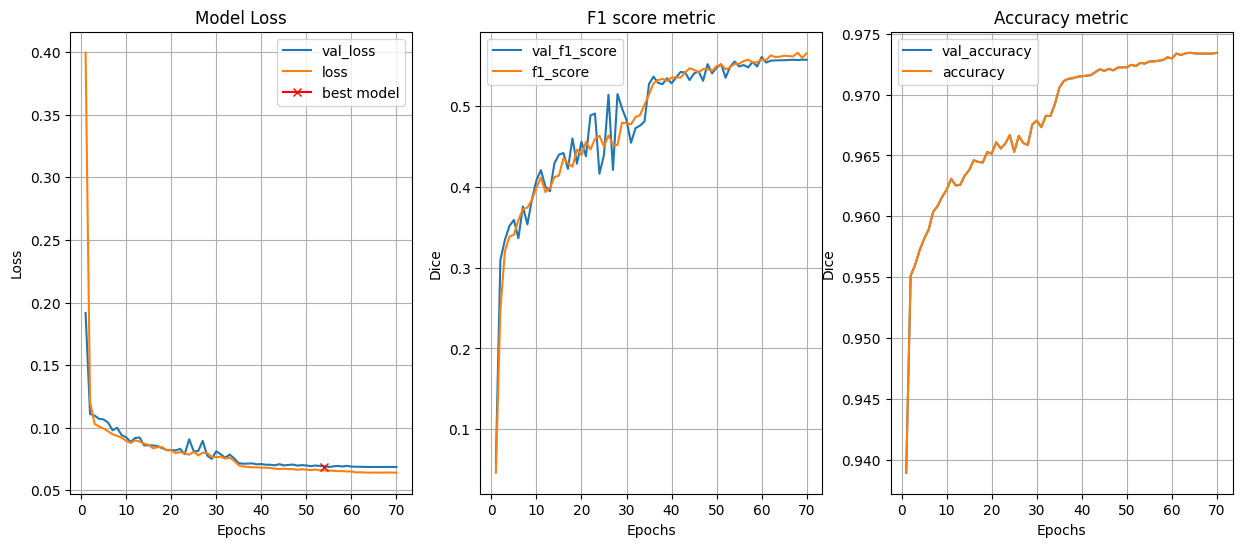

In [ ]:
unet_model = build_model(start_neurons = 32,IMG_WIDTH = 128,IMG_HEIGHT = 128,IMG_CHANNELS = 3)

optimizer = Adam(learning_rate = 1e-3)

unet_model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = [F1_score_homemade,'accuracy'])

callbacks = [
    ReduceLROnPlateau(monitor = 'val_loss' , patience = 5, factor = 0.1), #reduction du pas de recherche
    EarlyStopping(monitor = 'val_loss' , patience = 15, restore_best_weights = True), #stop le processus d'apprentissage si le modèle ne diminue pas la fonction coût
    ModelCheckpoint("model.checkpoint.h5", monitor = 'val_loss' , save_best_only = True) #Sauvegarde le modèle
    ]

history1_unet_model = unet_model.fit(Images_train_std, Masks_train_std,
                                     validation_data=(Images_test_std, Masks_test_std),
                                     shuffle = True , batch_size = 32, epochs = 100,
                                     callbacks = callbacks)

epochs = range (1,len(history1_unet_model.history['val_loss'])+1)
plt.figure(figsize = (15,6))

plt.subplot(131)
plt.title('Model Loss')
plt.plot(epochs, history1_unet_model.history['val_loss'],label = 'val_loss')
plt.plot(epochs, history1_unet_model.history['loss'],label = 'loss')
plt.plot(np.argmin(history1_unet_model.history['val_loss']) , np.min(history1_unet_model.history['val_loss']), marker = 'x', color = 'r', label = 'best model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(132)
plt.title('F1 score metric')
plt.plot(epochs, history1_unet_model.history['val_F1_score_homemade'],label = 'val_f1_score')
plt.plot(epochs, history1_unet_model.history['F1_score_homemade'],label = 'f1_score')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.grid()
plt.legend()

plt.subplot(133)
plt.title('Accuracy metric')
plt.plot(epochs, history1_unet_model.history['accuracy'],label = 'val_accuracy')
plt.plot(epochs, history1_unet_model.history['accuracy'],label = 'accuracy')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.grid()
plt.legend()

### Test 2

Essayons de diminuer la taille du batch_size et aussi changeons les patiences dans la partie callbacks

Epoch 1/100
277/277 [==============================] - ETA: 0s - loss: 0.1424 - F1_score_homemade: 0.2594 - accuracy: 0.9548

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


277/277 [==============================] - 19s 46ms/step - loss: 0.1424 - F1_score_homemade: 0.2594 - accuracy: 0.9548 - val_loss: 0.1101 - val_F1_score_homemade: 0.3234 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 2/100
277/277 [==============================] - 12s 45ms/step - loss: 0.0991 - F1_score_homemade: 0.3391 - accuracy: 0.9593 - val_loss: 0.1047 - val_F1_score_homemade: 0.4014 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 3/100
277/277 [==============================] - 12s 44ms/step - loss: 0.0988 - F1_score_homemade: 0.3445 - accuracy: 0.9595 - val_loss: 0.0961 - val_F1_score_homemade: 0.3488 - val_accuracy: 0.9618 - lr: 0.0010
Epoch 4/100
277/277 [==============================] - 12s 44ms/step - loss: 0.0963 - F1_score_homemade: 0.3579 - accuracy: 0.9608 - val_loss: 0.0938 - val_F1_score_homemade: 0.3592 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 5/100
277/277 [==============================] - 12s 43ms/step - loss: 0.0918 - F1_score_homemade: 0.3809 - accuracy: 0.9616 - val_los

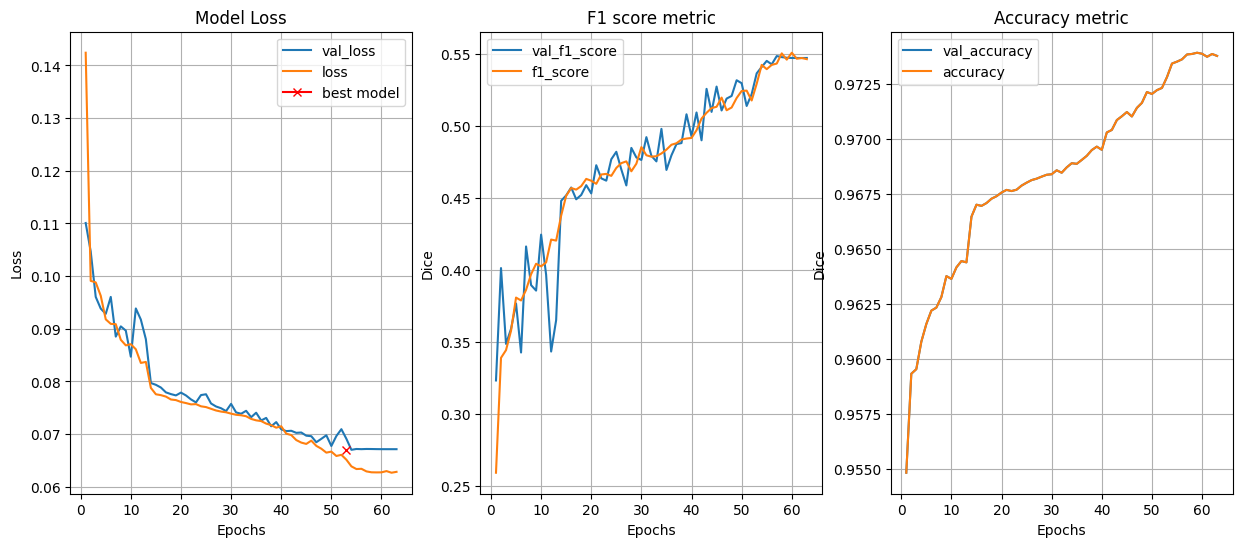

In [ ]:
unet_model2 = build_model(start_neurons = 32,IMG_WIDTH = 128,IMG_HEIGHT = 128,IMG_CHANNELS = 3)

optimizer = Adam(learning_rate = 1e-3)

unet_model2.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = [F1_score_homemade,'accuracy'])

callbacks = [
    ReduceLROnPlateau(monitor = 'val_loss' , patience = 3, factor = 0.1), #reduction du pas de recherche
    EarlyStopping(monitor = 'val_loss' , patience = 9, restore_best_weights = True), #stop le processus d'apprentissage si le modèle ne diminue pas la fonction coût
    ModelCheckpoint("model.checkpoint.h5", monitor = 'val_loss' , save_best_only = True) #Sauvegarde le modèle
    ]

history2_unet_model = unet_model2.fit(Images_train_std, Masks_train_std,
                                     validation_data=(Images_test_std, Masks_test_std),
                                     shuffle = True , batch_size = 5, epochs = 100,
                                     callbacks = callbacks)

epochs = range (1,len(history2_unet_model.history['val_loss'])+1)
plt.figure(figsize = (15,6))

plt.subplot(131)
plt.title('Model Loss')
plt.plot(epochs, history2_unet_model.history['val_loss'],label = 'val_loss')
plt.plot(epochs, history2_unet_model.history['loss'],label = 'loss')
plt.plot(np.argmin(history2_unet_model.history['val_loss']) , np.min(history2_unet_model.history['val_loss']), marker = 'x', color = 'r', label = 'best model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(132)
plt.title('F1 score metric')
plt.plot(epochs, history2_unet_model.history['val_F1_score_homemade'],label = 'val_f1_score')
plt.plot(epochs, history2_unet_model.history['F1_score_homemade'],label = 'f1_score')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.grid()
plt.legend()

plt.subplot(133)
plt.title('Accuracy metric')
plt.plot(epochs, history2_unet_model.history['accuracy'],label = 'val_accuracy')
plt.plot(epochs, history2_unet_model.history['accuracy'],label = 'accuracy')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.grid()
plt.legend()

Dans ce cas le score est moins bon et de l'overfitting est observé, nous n'allons pas choisir ce modèle.

### Évaluation du modèle 1

In [ ]:
eval_test = unet_model.evaluate(Images_val_std,Masks_val_std)

print('Test Loss : ' + str(eval_test[0]))
print('Test Metric : ' + str(eval_test[1]))

Masks_val_std_proba = unet_model.predict(Images_val_std)


13/13 [==============================] - 3s 214ms/step - loss: 0.0589 - F1_score_homemade: 0.5592 - accuracy: 0.9758
Test Loss : 0.05894165858626366
Test Metric : 0.5592289566993713
13/13 [==============================] - 1s 42ms/step


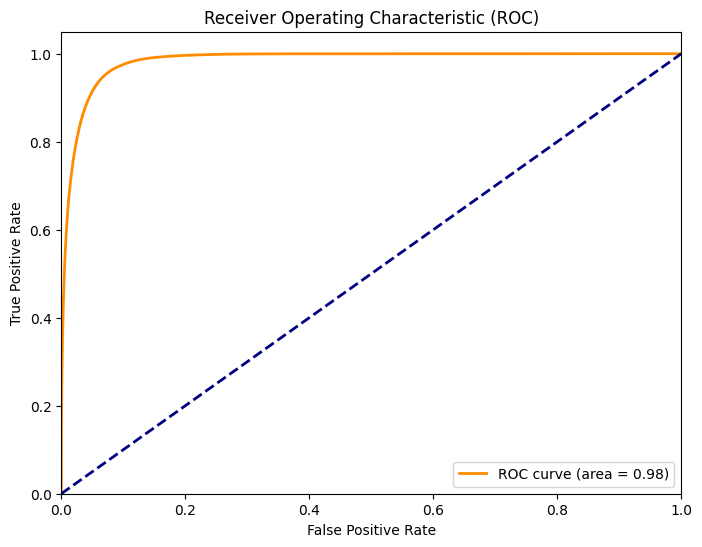

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Aplatir les true_masks et les proba_masks
score_val = Masks_val_std_proba.flatten()
true_values_val = Masks_val_std.flatten()

# Calculer les taux de vrais positifs, faux positifs et les seuils
fpr, tpr, thresholds = roc_curve(true_values_val, score_val)

# Calculer l'AUC # aire sous la courbe roc
auc = roc_auc_score(true_values_val, score_val)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Le seuil optimal est celui pour lequel la somme des carrés des distances à (0,1) pour chaque point est minimale.
optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
optimal_threshold = thresholds[optimal_idx]

print(f"Le seuil optimal est: {optimal_threshold}")

Le seuil optimal est: 0.047368962317705154


Nous allons choisir le seuil le plus proche du point (0,1) sur la courbe, c'est-à-dire le point qui maximise à la fois le taux de vrais positifs tout en minimisant le taux de faux positifs. Cela revient à minimiser la distance euclidienne au point (0,1) sur la courbe ROC

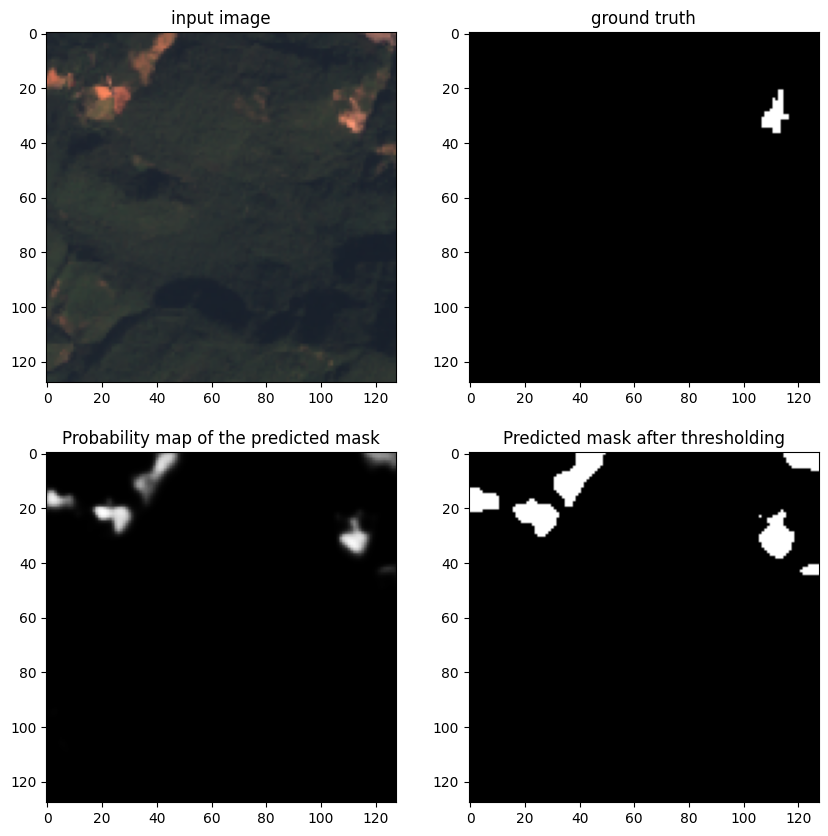

In [ ]:
Masks_val_std_pred = Masks_val_std_proba >0.05

ix = random.randint(0, len(Images_val_std))

fig = plt.figure(figsize = (10,10))
plt.subplot(221)
plt.imshow(cv2.cvtColor(Images_val_std[ix,:,:], cv2.COLOR_BGR2RGB))
plt.title("input image")

plt.subplot(222)
plt.imshow(np.squeeze(Masks_val_std[ix,:,:,0]), cmap='gray')
plt.title("ground truth")

plt.subplot(223)
plt.imshow(np.squeeze(Masks_val_std_proba[ix,:,:,0]), cmap='gray')
plt.title("Probability map of the predicted mask")

plt.subplot(224)
plt.imshow(np.squeeze(Masks_val_std_pred[ix,:,:,0]), cmap='gray')
plt.title("Predicted mask after thresholding")

plt.show()

Les classes étant tellement déséquilibrées, nous ne pourrons pas déterminer correctement un seuil descriminant à l'aide de la courbe ROC. Il y a trop de pixels noirs bien prédits, nous allons chercher à 'taton' un seuil qui nous semble acceptable (partie qui mériterait une expertise métier)

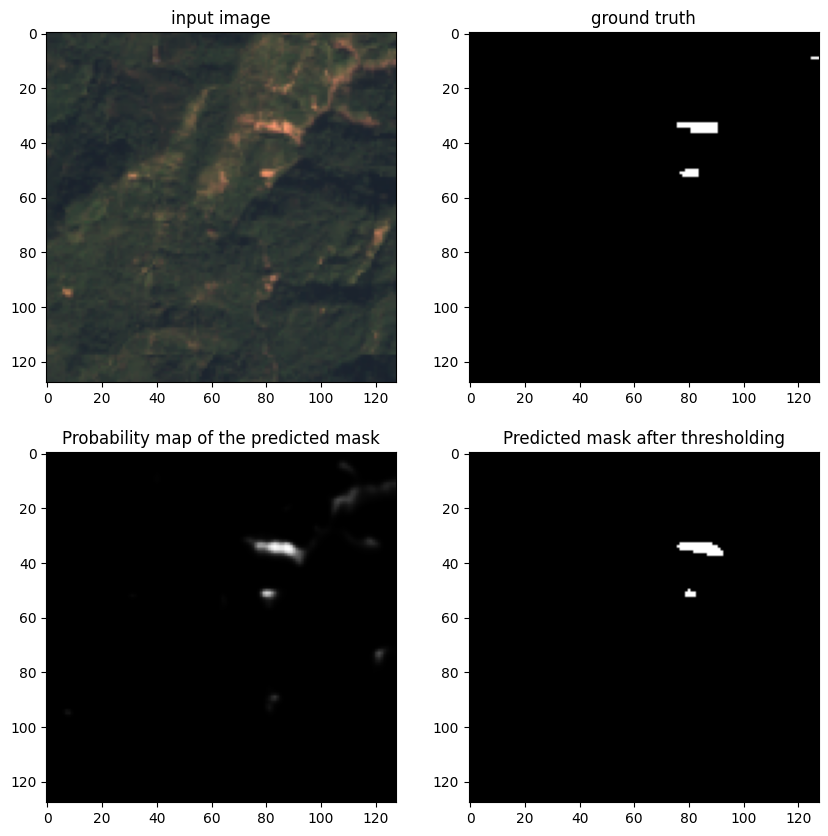

In [ ]:
Masks_val_std_pred = Masks_val_std_proba >0.3

ix = random.randint(0, len(Images_val_std))

fig = plt.figure(figsize = (10,10))
plt.subplot(221)
plt.imshow(cv2.cvtColor(Images_val_std[ix,:,:], cv2.COLOR_BGR2RGB))
plt.title("input image")

plt.subplot(222)
plt.imshow(np.squeeze(Masks_val_std[ix,:,:,0]), cmap='gray')
plt.title("ground truth")

plt.subplot(223)
plt.imshow(np.squeeze(Masks_val_std_proba[ix,:,:,0]), cmap='gray')
plt.title("Probability map of the predicted mask")

plt.subplot(224)
plt.imshow(np.squeeze(Masks_val_std_pred[ix,:,:,0]), cmap='gray')
plt.title("Predicted mask after thresholding")

plt.show()

In [ ]:
# F1 Score pour les données de validation sans approximation :
score_val = Masks_val_std_proba.flatten()
true_values_val = Masks_val_std.flatten()
score_val = (score_val>0.3).astype(np.float32)

true_positives = np.sum(true_values_val * score_val) # on a :  0*0 = 1*0 = 0*1 = 0 != 1*1 = 1 on obtient ainsi les vrais positifs
predicted_positives = np.sum(score_val)
all_positives = np.sum(true_values_val)

precision = true_positives / predicted_positives
recall = true_positives / all_positives

f1_score = 2 * (precision * recall) / (precision + recall )

print(f'F1_score du modèle1 : {f1_score:.2f}')



F1_score du modèle1 : 0.69


Le F1 score est meilleur que prévu pour le modèle1 sur les données de validation.

### Avec un modèle Unet une peu plus profond et plus de paramètres

Epoch 1/100
44/44 [==============================] - 21s 308ms/step - loss: 0.5181 - F1_score_homemade: 0.0530 - accuracy: 0.9360 - val_loss: 0.2367 - val_F1_score_homemade: 0.0582 - val_accuracy: 0.9537 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 13s 296ms/step - loss: 0.1477 - F1_score_homemade: 0.1822 - accuracy: 0.9550 - val_loss: 0.1241 - val_F1_score_homemade: 0.2880 - val_accuracy: 0.9537 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 13s 299ms/step - loss: 0.1091 - F1_score_homemade: 0.2998 - accuracy: 0.9551 - val_loss: 0.1137 - val_F1_score_homemade: 0.2964 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 13s 297ms/step - loss: 0.1038 - F1_score_homemade: 0.3280 - accuracy: 0.9579 - val_loss: 0.1120 - val_F1_score_homemade: 0.3390 - val_accuracy: 0.9573 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 13s 294ms/step - loss: 0.1022 - F1_score_homemade: 0.3423 - accuracy: 0.9592 - 

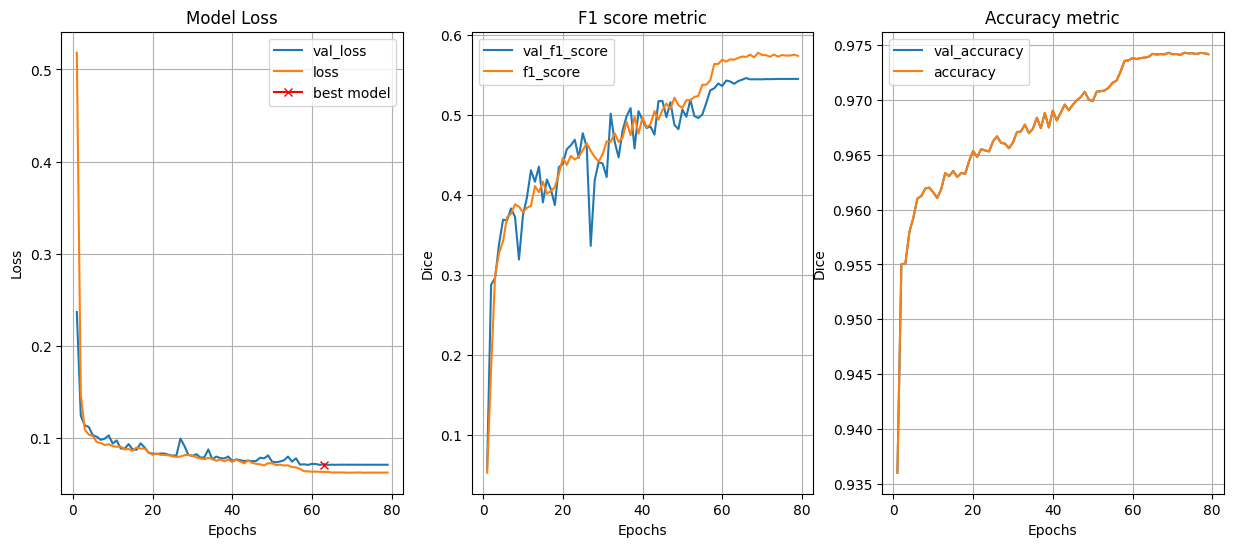

In [ ]:
unet_model_deeper = build_model_deeper(start_neurons = 32,IMG_WIDTH = 128,IMG_HEIGHT = 128,IMG_CHANNELS = 3)

optimizer = Adam(learning_rate = 1e-3)

unet_model_deeper.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = [F1_score_homemade,'accuracy'])

callbacks = [
    ReduceLROnPlateau(monitor = 'val_loss' , patience = 5, factor = 0.1), #reduction du pas de recherche
    EarlyStopping(monitor = 'val_loss' , patience = 15, restore_best_weights = True), #stop le processus d'apprentissage si le modèle ne diminue pas la fonction coût
    ModelCheckpoint("model.checkpoint.h5", monitor = 'val_loss' , save_best_only = True) #Sauvegarde le modèle
    ]

history_unet_model_deeper = unet_model_deeper.fit(Images_train_std, Masks_train_std,
                                     validation_data=(Images_test_std, Masks_test_std),
                                     shuffle = True , batch_size = 32, epochs = 100,
                                     callbacks = callbacks)

epochs = range (1,len(history_unet_model_deeper.history['val_loss'])+1)
plt.figure(figsize = (15,6))

plt.subplot(131)
plt.title('Model Loss')
plt.plot(epochs, history_unet_model_deeper.history['val_loss'],label = 'val_loss')
plt.plot(epochs, history_unet_model_deeper.history['loss'],label = 'loss')
plt.plot(np.argmin(history_unet_model_deeper.history['val_loss']) , np.min(history_unet_model_deeper.history['val_loss']), marker = 'x', color = 'r', label = 'best model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(132)
plt.title('F1 score metric')
plt.plot(epochs, history_unet_model_deeper.history['val_F1_score_homemade'],label = 'val_f1_score')
plt.plot(epochs, history_unet_model_deeper.history['F1_score_homemade'],label = 'f1_score')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.grid()
plt.legend()

plt.subplot(133)
plt.title('Accuracy metric')
plt.plot(epochs, history_unet_model_deeper.history['accuracy'],label = 'val_accuracy')
plt.plot(epochs, history_unet_model_deeper.history['accuracy'],label = 'accuracy')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.grid()
plt.legend()

In [ ]:
eval_test_deeper = unet_model_deeper.evaluate(Images_val_std,Masks_val_std)

print('Test Loss' + str(eval_test_deeper[0]))
print('Test Metric' + str(eval_test_deeper[1]))

Masks_val_std_proba_deeper = unet_model_deeper.predict(Images_val_std)
Masks_val_std_pred_deeper = Masks_val_std_proba_deeper >0.4


13/13 [==============================] - 1s 73ms/step - loss: 0.0592 - F1_score_homemade: 0.5602 - accuracy: 0.9758
Test Loss0.059181131422519684
Test Metric0.5601744055747986
13/13 [==============================] - 1s 68ms/step


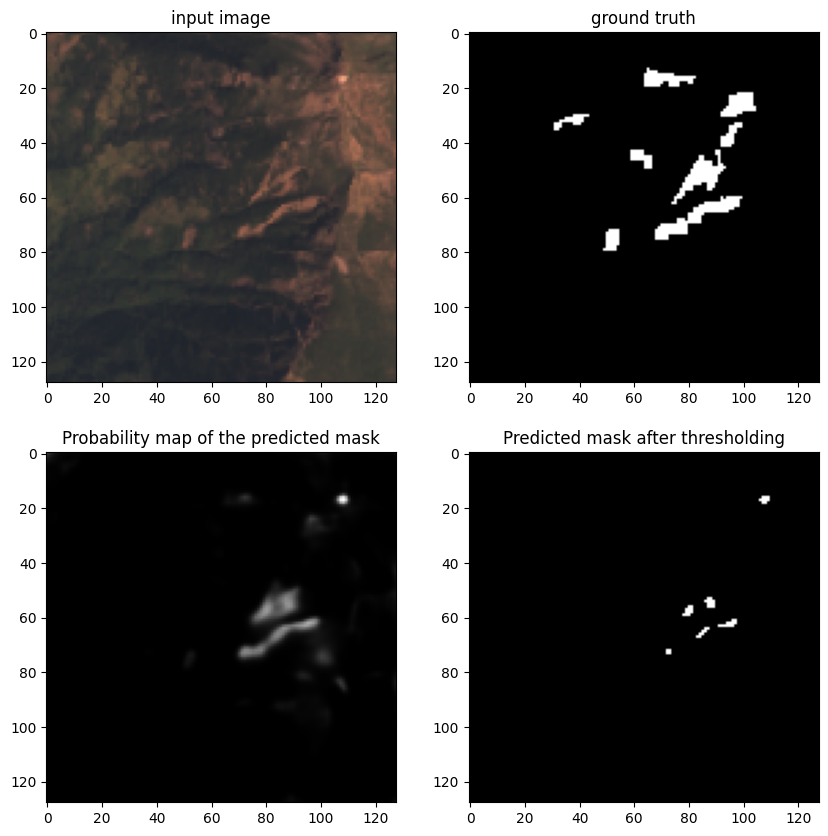

In [ ]:

ix = random.randint(0, len(Images_val_std))

fig = plt.figure(figsize = (10,10))
plt.subplot(221)
plt.imshow(cv2.cvtColor(Images_val_std[ix,:,:], cv2.COLOR_BGR2RGB))
plt.title("input image")

plt.subplot(222)
plt.imshow(np.squeeze(Masks_val_std[ix,:,:,0]), cmap='gray')
plt.title("ground truth")

plt.subplot(223)
plt.imshow(np.squeeze(Masks_val_std_proba_deeper[ix,:,:,0]), cmap='gray')
plt.title("Probability map of the predicted mask")

plt.subplot(224)
plt.imshow(np.squeeze(Masks_val_std_pred_deeper[ix,:,:,0]), cmap='gray')
plt.title("Predicted mask after thresholding")

plt.show()

In [ ]:
# F1 Score pour les données de validation sans approximation :
score_val_deeper = Masks_val_std_pred_deeper.flatten()
true_values_val = Masks_val_std.flatten()
score_val_deeper = (score_val>0.3).astype(np.float32)

true_positives_deeper = np.sum(true_values_val * score_val_deeper) # on a :  0*0 = 1*0 = 0*1 = 0 != 1*1 = 1 on obtient ainsi les vrais positifs
predicted_positives_deeper = np.sum(score_val_deeper)
all_positives = np.sum(true_values_val)

precision_deeper = true_positives_deeper / predicted_positives_deeper
recall_deeper = true_positives_deeper / all_positives

f1_score_deeper = 2 * (precision_deeper * recall_deeper) / (precision_deeper + recall_deeper )

print(f'F1_score du modèle1 : {f1_score_deeper:.2f}')

F1_score du modèle1 : 0.68


Le modèle Unet plus profond et avec plus de paramètres ne semble pas nous donner de meilleures prédictions. Nous allons rester sur le modèle simple.

# Entrainement avec data augmentation

In [ ]:
Images_train, Masks_train = list_images_masks_parallel(train_path_images, train_path_masks)
Images_test, Masks_test = list_images_masks_parallel(test_path_images, test_path_masks)
Images_val, Masks_val = list_images_masks_parallel(val_path_images, val_path_masks)

1385it [00:00, 43615.22it/s]
199it [00:00, 30521.32it/s]
396it [00:00, 43320.32it/s]


In [ ]:

def data_augmentation(Images, Masks):
  Images_augmented = []
  Masks_augmented = []

  n = len(Images)

  for i in tqdm(range(n)):
    image = Images[i]
    mask = Masks[i]

    # Ajouts basiques
    Images_augmented.append(image)
    Masks_augmented.append(mask)

    # Rotation
    k_rot = np.random.randint(1, 4)
    Images_augmented.append(np.rot90(image, k=k_rot))
    Masks_augmented.append(np.rot90(mask, k=k_rot))

    # Miroir
    ax = np.random.randint(0, 2)
    Images_augmented.append(np.flip(image, axis=ax))
    Masks_augmented.append(np.flip(mask, axis=ax))

    # Ajustement du contraste
    contrast_image = adjust_contrast(image,alpha=1.5 + 0.25*np.random.randn())
    Images_augmented.append(contrast_image)
    Masks_augmented.append(mask)

    # Modification de la saturation
    sat_image = change_saturation(image,beta=50*np.random.randn())
    Images_augmented.append(sat_image)
    Masks_augmented.append(mask)


  Images_augmented = np.array(Images_augmented)
  Masks_augmented = np.array(Masks_augmented)

  indices = np.arange(Images_augmented.shape[0])
  np.random.shuffle(indices) #mélange les indices

  Images_augmented = Images_augmented[indices]
  Masks_augmented = Masks_augmented[indices]

  return Images_augmented, Masks_augmented


def adjust_contrast(image, alpha=1.5):
    """Ajuste le contraste de l'image. Alpha > 1 augmente le contraste."""
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=0)
    return new_image

def change_saturation(image, beta=50):
    """Change la saturation de l'image. Beta est ajouté à la valeur de saturation."""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    s = cv2.add(s, beta)
    s = np.clip(s, 0, 255)
    hsv = cv2.merge([h, s, v])
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return new_img

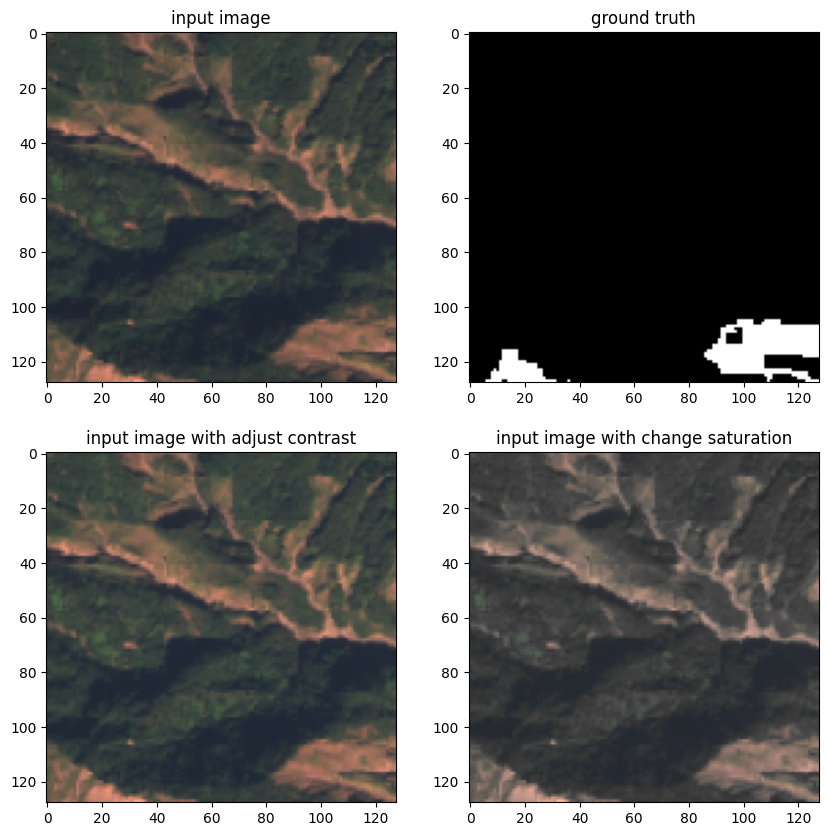

In [ ]:
ix = random.randint(0, len(Images_train))

fig = plt.figure(figsize = (10,10))
plt.subplot(221)
plt.imshow(cv2.cvtColor(Images_train[ix], cv2.COLOR_BGR2RGB))
plt.title("input image")

plt.subplot(222)
plt.imshow(np.squeeze(Masks_train[ix,:,:,0]), cmap='gray')
plt.title("ground truth")

plt.subplot(223)
plt.imshow(cv2.cvtColor(adjust_contrast(Images_train[ix],alpha=1.5 + 0.25*np.random.randn()), cv2.COLOR_BGR2RGB))
plt.title("input image with adjust contrast")

plt.subplot(224)
plt.imshow(cv2.cvtColor(change_saturation(Images_train[ix],beta=50*np.random.randn()), cv2.COLOR_BGR2RGB))
plt.title("input image with change saturation")

plt.show()

In [ ]:
Images_train_da, Masks_train_da  = data_augmentation(Images_train, Masks_train)
Images_test_da, Masks_test_da = data_augmentation(Images_test, Masks_test)
Images_val_da, Masks_val_da = data_augmentation(Images_val, Masks_val)

## Normalisation
Images_train_da_std, Masks_train_da_std = min_max(Images_train_da,Masks_train_da)
Images_test_da_std, Masks_test_da_std = min_max(Images_test_da,Masks_test_da)

100%|██████████| 396/396 [00:00<00:00, 4121.46it/s]


In [ ]:

unet_model_da = build_model(start_neurons = 32,IMG_WIDTH = 128,IMG_HEIGHT = 128,IMG_CHANNELS = 3)

optimizer = Adam(learning_rate = 1e-3)

unet_model_da.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = [F1_score_homemade,'accuracy'])

callbacks = [
    ReduceLROnPlateau(monitor = 'val_loss' , patience = 5, factor = 0.1), #reduction du pas de recherche
    EarlyStopping(monitor = 'val_loss' , patience = 15, restore_best_weights = True), #stop le processus d'apprentissage si le modèle ne diminue pas la fonction coût
    ModelCheckpoint("model.checkpoint.h5", monitor = 'val_loss' , save_best_only = True) #Sauvegarde le modèle
    ]

history_unet_model_da = unet_model_da.fit(Images_train_da_std, Masks_train_da_std,
                                     validation_data=(Images_test_da_std, Masks_test_da_std),
                                     shuffle = True , batch_size = 32, epochs = 100,
                                     callbacks = callbacks)

Epoch 1/100
217/217 [==============================] - ETA: 0s - loss: 0.1678 - F1_score_homemade: 0.2552 - accuracy: 0.9530

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


217/217 [==============================] - 54s 222ms/step - loss: 0.1678 - F1_score_homemade: 0.2552 - accuracy: 0.9530 - val_loss: 0.1065 - val_F1_score_homemade: 0.3014 - val_accuracy: 0.9578 - lr: 0.0010
Epoch 2/100
217/217 [==============================] - 45s 209ms/step - loss: 0.0937 - F1_score_homemade: 0.3725 - accuracy: 0.9607 - val_loss: 0.0919 - val_F1_score_homemade: 0.3867 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 3/100
217/217 [==============================] - 46s 210ms/step - loss: 0.0889 - F1_score_homemade: 0.3980 - accuracy: 0.9617 - val_loss: 0.0881 - val_F1_score_homemade: 0.3903 - val_accuracy: 0.9616 - lr: 0.0010
Epoch 4/100
217/217 [==============================] - 46s 210ms/step - loss: 0.0863 - F1_score_homemade: 0.4104 - accuracy: 0.9625 - val_loss: 0.0855 - val_F1_score_homemade: 0.4121 - val_accuracy: 0.9635 - lr: 0.0010
Epoch 5/100
217/217 [==============================] - 45s 208ms/step - loss: 0.0842 - F1_score_homemade: 0.4241 - accuracy: 0.9634 - va

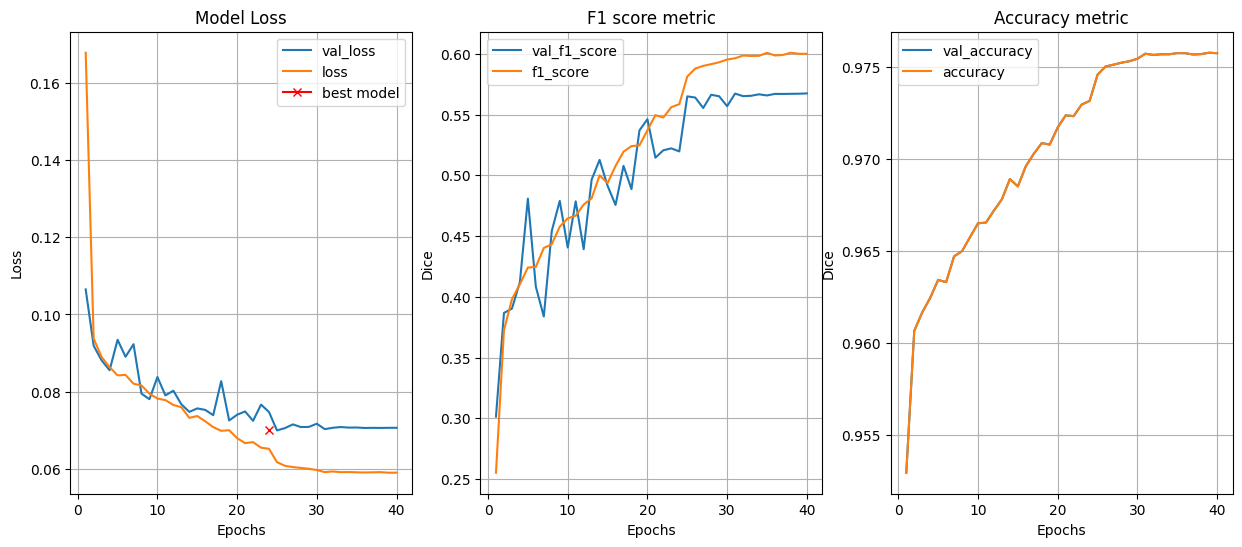

In [ ]:
epochs = range (1,len(history_unet_model_da.history['val_loss'])+1)
plt.figure(figsize = (15,6))

plt.subplot(131)
plt.title('Model Loss')
plt.plot(epochs, history_unet_model_da.history['val_loss'],label = 'val_loss')
plt.plot(epochs, history_unet_model_da.history['loss'],label = 'loss')
plt.plot(np.argmin(history_unet_model_da.history['val_loss']) , np.min(history_unet_model_da.history['val_loss']), marker = 'x', color = 'r', label = 'best model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(132)
plt.title('F1 score metric')
plt.plot(epochs, history_unet_model_da.history['val_F1_score_homemade'],label = 'val_f1_score')
plt.plot(epochs, history_unet_model_da.history['F1_score_homemade'],label = 'f1_score')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.grid()
plt.legend()

plt.subplot(133)
plt.title('Accuracy metric')
plt.plot(epochs, history_unet_model_da.history['accuracy'],label = 'val_accuracy')
plt.plot(epochs, history_unet_model_da.history['accuracy'],label = 'accuracy')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.grid()
plt.legend()

In [ ]:
evaluation_da = unet_model_da.evaluate(Images_val_std,Masks_val_std)

print('Test Loss' + str(evaluation_da[0]))
print('Test Metric' + str(evaluation_da[1]))

Masks_val_da_std_proba = unet_model_da.predict(Images_val_std)
Masks_val_da_std_pred = Masks_val_da_std_proba >0.4

13/13 [==============================] - 1s 47ms/step - loss: 0.0563 - F1_score_homemade: 0.5907 - accuracy: 0.9767
Test Loss0.05629826709628105
Test Metric0.5907400846481323
13/13 [==============================] - 1s 43ms/step


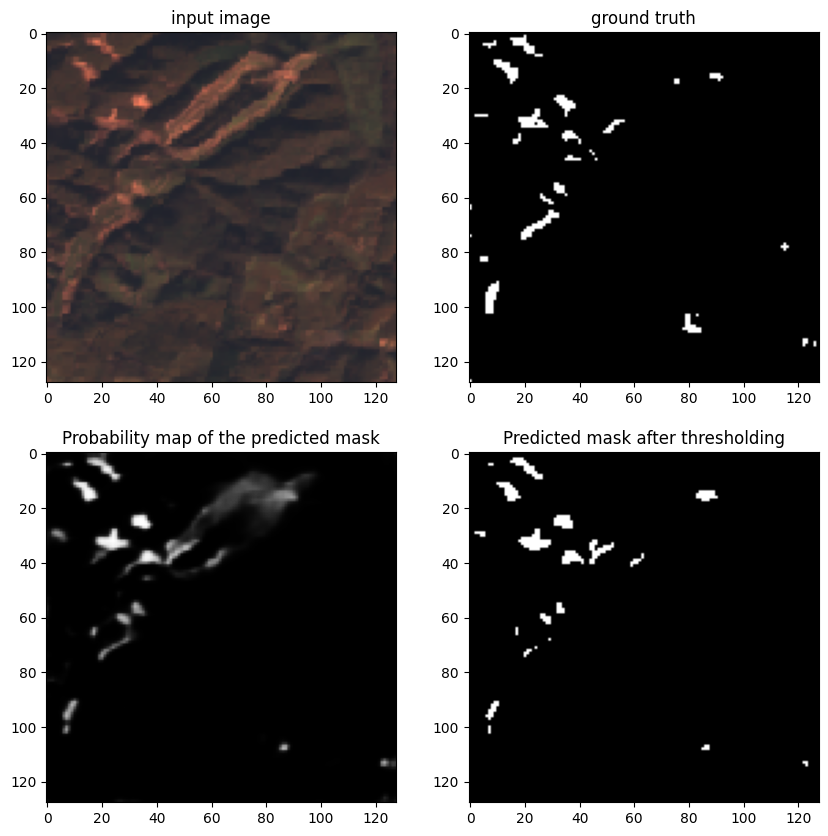

In [ ]:
ix = random.randint(0, len(Images_val))

fig = plt.figure(figsize = (10,10))
plt.subplot(221)
plt.imshow(cv2.cvtColor(Images_val_std[ix], cv2.COLOR_BGR2RGB))
plt.title("input image")

plt.subplot(222)
plt.imshow(np.squeeze(Masks_val_std[ix]), cmap='gray')
plt.title("ground truth")

plt.subplot(223)
plt.imshow(np.squeeze(Masks_val_da_std_proba[ix]), cmap='gray')
plt.title("Probability map of the predicted mask")

plt.subplot(224)
plt.imshow(np.squeeze(Masks_val_da_std_pred[ix]), cmap='gray')
plt.title("Predicted mask after thresholding")

plt.show()

In [ ]:
# F1 Score pour les données de validation sans approximation :
score_val = Masks_val_da_std_pred.flatten()
true_values_val = Masks_val_std.flatten()

true_positives = np.sum(true_values_val * score_val) # on a :  0*0 = 1*0 = 0*1 = 0 != 1*1 = 1 on obtient ainsi les vrais positifs
predicted_positives = np.sum(score_val)
all_positives = np.sum(true_values_val)

precision = true_positives / predicted_positives
recall = true_positives / all_positives

f1_score = 2 * (precision * recall) / (precision + recall )

print(f'F1_score du modèle avec data augmentation: {f1_score:.2f}')

F1_score du modèle avec data augmentation: 0.70


Nous remarquons que la data augmentation n'améliore pas nos prédictions considérablement, de plus on observe de l'overfitting sur les données d'entrainement en lien avec la data augmentation.  
